In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/"

'cat emotion project.ipynb'   model_cat_emotion.h5
'Cat Emotions'		      test_image-20260107T105652Z-3-001


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/Cat Emotions"

README.dataset.txt  README.roboflow.txt  train	valid


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Cat Emotions"   # change if needed
IMG_SIZE = 224         # standard for ResNet / EfficientNet
BATCH_SIZE = 16
NUM_WORKERS = 2

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_transforms = transforms.Compose([

    # 1️⃣ Resize FIRST
    transforms.Resize((224, 224)),

    # 2️⃣ Reflection padding to protect borders
    transforms.Pad(
        padding=16,
        padding_mode="reflect"
    ),

    # 3️⃣ Small safe rotation
    transforms.RandomRotation(
        degrees=7,
        interpolation=transforms.InterpolationMode.BILINEAR
    ),

    # 4️⃣ Center crop back to 224
    transforms.CenterCrop(224),

    # 5️⃣ Horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),

    # 6️⃣ Light color jitter
    transforms.ColorJitter(
        brightness=0.12,
        contrast=0.12,
        saturation=0.12
    ),

    # 7️⃣ Tensor + normalize
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
from torchvision import datasets

TRAIN_DIR = "/content/drive/MyDrive/Colab Notebooks/Cat Emotions/train"

train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=train_transforms
)

VAL_DIR = "/content/drive/MyDrive/Colab Notebooks/Cat Emotions/valid"

val_dataset = datasets.ImageFolder(
    root=VAL_DIR,
    transform=val_transforms
)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)
print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))


Classes: ['Angry', 'Disgusted', 'Happy', 'Normal', 'Sad', 'Scared', 'Surprised']
Number of classes: 7
Train images: 502
Val images: 169


In [ ]:
print(len(train_dataset), len(val_dataset))

502 169


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

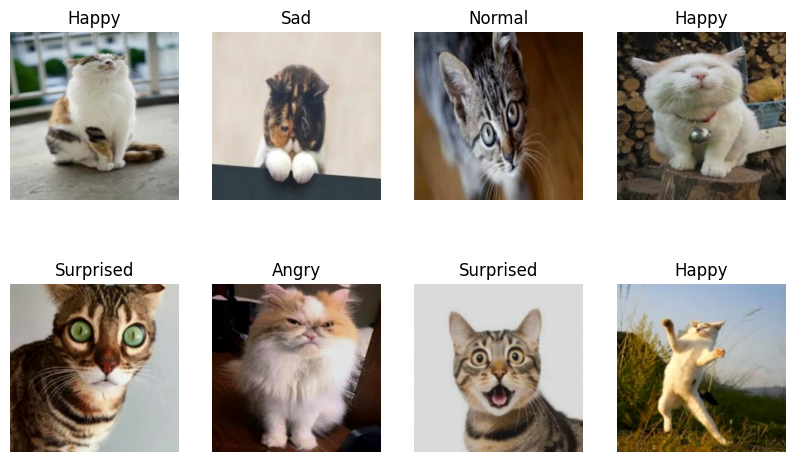

In [ ]:
def show_batch(images, labels):
    images = images.permute(0, 2, 3, 1)
    images = images * torch.tensor([0.229, 0.224, 0.225]) + \
             torch.tensor([0.485, 0.456, 0.406])
    images = images.numpy()

    plt.figure(figsize=(10, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 7  # Angry, Disgusted, Happy, Normal, Sad, Scared, Surprised

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [ ]:
model = model.to(device)

In [ ]:
x = torch.randn(1, 3, 224, 224).to(device)
y = model(x)
print("Output shape:", y.shape)

Output shape: torch.Size([1, 7])


In [ ]:
from collections import Counter

targets = [label for _, label in train_dataset.samples]
class_count = Counter(targets)

num_classes = len(class_count)

class_weights = torch.tensor(
    [1.0 / class_count[i] for i in range(num_classes)],
    dtype=torch.float
)

class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

print("Class weights:", class_weights)

Class weights: tensor([0.1432, 0.1643, 0.1643, 0.1355, 0.1591, 0.1269, 0.1066],
       device='cuda:0')


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)

In [ ]:
trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)

total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable_params}")
print(f"Total params: {total_params}")

Trainable params: 3591
Total params: 11180103


In [ ]:
EPOCHS = 30
PATIENCE = 5          # early stopping patience
best_val_loss = float("inf")
patience_counter = 0

In [ ]:
def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    print("-" * 30)

    # =====================
    # 🔥 Training Phase
    # =====================
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy_from_logits(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = running_acc / len(train_loader)

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # =====================
    # 🧪 Validation Phase
    # =====================
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_acc += accuracy_from_logits(outputs, labels)

    epoch_val_loss = running_loss / len(val_loader)
    epoch_val_acc = running_acc / len(val_loader)

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # =====================
    # 📈 Logging
    # =====================
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.4f}")

    # =====================
    # ⏹️ Early Stopping
    # =====================
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0

        torch.save(model.state_dict(), "best_cat_emotion_model.pth")
        print("✅ Best model saved")

    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break


Epoch [1/30]
------------------------------
Train Loss: 1.9537 | Train Acc: 0.1960
Val   Loss: 1.9456 | Val   Acc: 0.1698
✅ Best model saved

Epoch [2/30]
------------------------------
Train Loss: 1.7244 | Train Acc: 0.3620
Val   Loss: 1.8156 | Val   Acc: 0.2633
✅ Best model saved

Epoch [3/30]
------------------------------
Train Loss: 1.5102 | Train Acc: 0.4694
Val   Loss: 1.5413 | Val   Acc: 0.4495
✅ Best model saved

Epoch [4/30]
------------------------------
Train Loss: 1.3942 | Train Acc: 0.5521
Val   Loss: 1.5197 | Val   Acc: 0.3908
✅ Best model saved

Epoch [5/30]
------------------------------
Train Loss: 1.3153 | Train Acc: 0.5645
Val   Loss: 1.4609 | Val   Acc: 0.4678
✅ Best model saved

Epoch [6/30]
------------------------------
Train Loss: 1.2455 | Train Acc: 0.5951
Val   Loss: 1.4049 | Val   Acc: 0.5265
✅ Best model saved

Epoch [7/30]
------------------------------
Train Loss: 1.1722 | Train Acc: 0.6068
Val   Loss: 1.4197 | Val   Acc: 0.5038
⚠️ No improvement (1/5)



In [ ]:
model.load_state_dict(torch.load("best_cat_emotion_model.pth"))
print("Best model loaded successfully")

Best model loaded successfully


In [ ]:
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

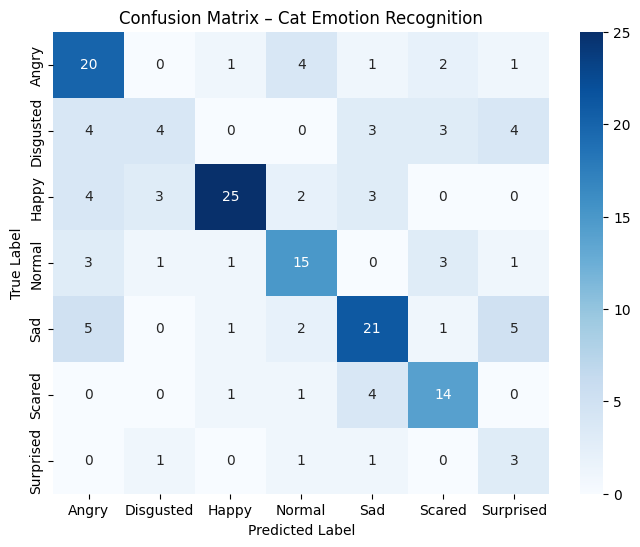

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Cat Emotion Recognition")
plt.show()

In [ ]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
)

              precision    recall  f1-score   support

       Angry     0.5556    0.6897    0.6154        29
   Disgusted     0.4444    0.2222    0.2963        18
       Happy     0.8621    0.6757    0.7576        37
      Normal     0.6000    0.6250    0.6122        24
         Sad     0.6364    0.6000    0.6176        35
      Scared     0.6087    0.7000    0.6512        20
   Surprised     0.2143    0.5000    0.3000         6

    accuracy                         0.6036       169
   macro avg     0.5602    0.5732    0.5500       169
weighted avg     0.6280    0.6036    0.6056       169



In [ ]:
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print("Macro F1-score:", round(macro_f1, 4))

Macro F1-score: 0.55


In [ ]:
# Freeze everything first (safety)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last ResNet block
for param in model.layer4.parameters():
    param.requires_grad = True

# Also keep classifier trainable
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable_params}")
print(f"Total params: {total_params}")

Trainable params: 8397319
Total params: 11180103


In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4   # 🔴 LOWER than before
)

In [ ]:
EPOCHS = 20          # fewer epochs
PATIENCE = 5
best_val_loss = float("inf")
patience_counter = 0

In [ ]:
for epoch in range(EPOCHS):
    print(f"\nFine-tune Epoch [{epoch+1}/{EPOCHS}]")
    print("-" * 35)

    # 🔥 Training
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).float().mean().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # 🧪 Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).float().mean().item()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_finetuned_model.pth")
        print("✅ Best fine-tuned model saved")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break



Fine-tune Epoch [1/20]
-----------------------------------
Train Loss: 0.9387 | Train Acc: 0.7077
Val   Loss: 1.2638 | Val   Acc: 0.5505
✅ Best fine-tuned model saved

Fine-tune Epoch [2/20]
-----------------------------------
Train Loss: 0.4318 | Train Acc: 0.8848
Val   Loss: 1.0671 | Val   Acc: 0.6231
✅ Best fine-tuned model saved

Fine-tune Epoch [3/20]
-----------------------------------
Train Loss: 0.2344 | Train Acc: 0.9447
Val   Loss: 1.0582 | Val   Acc: 0.6515
✅ Best fine-tuned model saved

Fine-tune Epoch [4/20]
-----------------------------------
Train Loss: 0.1562 | Train Acc: 0.9688
Val   Loss: 1.0701 | Val   Acc: 0.6698
⚠️ No improvement (1/5)

Fine-tune Epoch [5/20]
-----------------------------------
Train Loss: 0.1048 | Train Acc: 0.9824
Val   Loss: 1.1337 | Val   Acc: 0.6187
⚠️ No improvement (2/5)

Fine-tune Epoch [6/20]
-----------------------------------
Train Loss: 0.0536 | Train Acc: 0.9980
Val   Loss: 1.0908 | Val   Acc: 0.6345
⚠️ No improvement (3/5)

Fine-tune

In [ ]:
model.load_state_dict(torch.load("best_finetuned_model.pth"))
print("Best fine-tuned model loaded")

Best fine-tuned model loaded


In [ ]:
model.load_state_dict(torch.load("best_finetuned_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

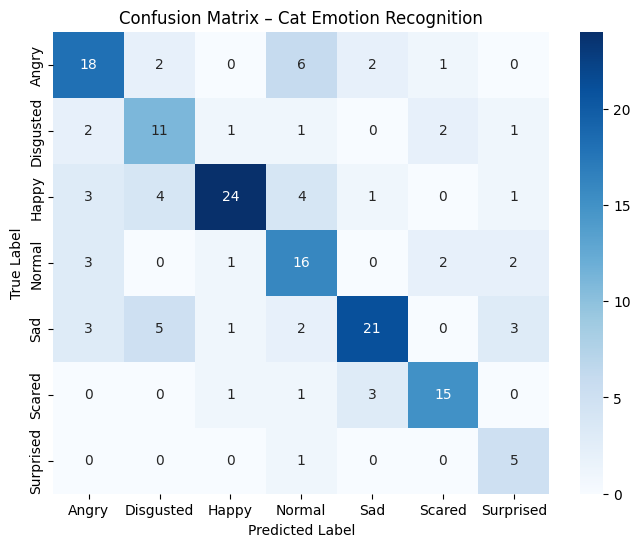

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Cat Emotion Recognition")
plt.show()

In [ ]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
)

              precision    recall  f1-score   support

       Angry     0.6207    0.6207    0.6207        29
   Disgusted     0.5000    0.6111    0.5500        18
       Happy     0.8571    0.6486    0.7385        37
      Normal     0.5161    0.6667    0.5818        24
         Sad     0.7778    0.6000    0.6774        35
      Scared     0.7500    0.7500    0.7500        20
   Surprised     0.4167    0.8333    0.5556         6

    accuracy                         0.6509       169
   macro avg     0.6341    0.6758    0.6391       169
weighted avg     0.6853    0.6509    0.6582       169



In [ ]:
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print("Macro F1-score:", round(macro_f1, 4))

Macro F1-score: 0.6391


Saving cat_test15.jpg to cat_test15.jpg


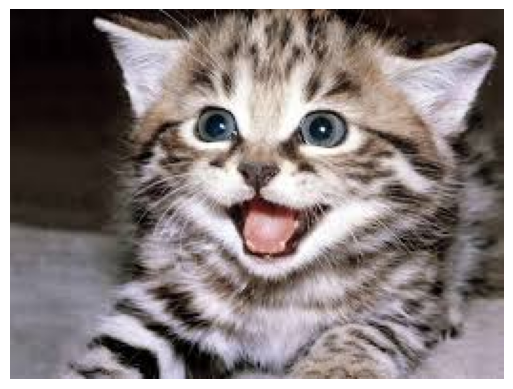

Top Predictions:
Happy : 94.71%
Scared : 1.59%


In [ ]:
from google.colab import files
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------
# UPLOAD IMAGE
# -----------------------------
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# -----------------------------
# DEVICE
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# CLASS ORDER (MATCH TRAINING)
# -----------------------------
class_names = [
    "Angry",
    "Disgusted",
    "Happy",
    "Normal",
    "Sad",
    "Scared",
    "Surprised"
]

# -----------------------------
# TRANSFORM (CORRECT)
# -----------------------------
infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# -----------------------------
# LOAD MODEL
# -----------------------------
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model.load_state_dict(
    torch.load("/content/best_finetuned_model.pth", map_location=device)
)

model = model.to(device)
model.eval()

# -----------------------------
# LOAD & SHOW IMAGE
# -----------------------------
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.show()

# -----------------------------
# PREPROCESS
# -----------------------------
image_tensor = infer_transform(image).unsqueeze(0).to(device)

# -----------------------------
# PREDICTION (TOP-2 FIX)
# -----------------------------
with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.softmax(outputs, dim=1)

top2 = torch.topk(probs, 2)

print("Top Predictions:")
for i in range(2):
    idx = top2.indices[0][i].item()
    conf = top2.values[0][i].item() * 100
    print(f"{class_names[idx]} : {conf:.2f}%")
